In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy import constants
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod

In [47]:
def g_mol_to_kg(mass):
    """
    Converts mass (g/mol) to mass (kg)
    """
    return mass / constants.Avogadro * 1e-3

In [89]:
def harmonic_PE(r, k, r0):
    """
    Computes harmonic potential energy

    Parameters:
        r (angstrom): separation distance
        k (N/angstrom): spring constant
        r0 (angstrom): equilibrium bond length

    Returns:
        Harmonic potential energy (eV)
    """
    e_J = 0.5 * k * ((r-r0)**2) * 1e-10
    return e_J / constants.eV

def harmonic_force(r_vec, k, r0):
    """
    Computes the magnitude of the force due to the harmonic bond potential.

    Parameters:
        r_vec (angstrom): displacement vector
        k (N/angstrom): spring constant
        r0 (angstrom): equilibrium bond length

    Returns:
        Magnitude of the force due to the harmonic bond potential (N)
    """
    r = np.linalg.norm(r_vec)
    return -k * (r-r0) * r_vec / r

well_coeff = 2**(1/6)
def repulsive_lj(r, sigma, epsilon):
    """
    Computes the repulsive Lennard-Jones potential energy.

    Parameters:
        r (angstrom): separation distance
        sigma (angstrom): distance where the potential energy is 0
        epsilon (eV): well depth

    Returns:
        lj potential energy (eV)
    """
    if r < well_coeff*sigma:
        sixth_pow = (sigma/r) ** 6
        return 4 * epsilon * (sixth_pow**2 - sixth_pow + 1/4)
    else:
        return 0

def repulsive_lj_force(r_vec, sigma, epsilon):
    """
    Computes the force due to repulsive Lennard-Jones potential energy.

    Parameters:
        r_vec (angstrom): displacement vector
        sigma (angstrom): distance where the potential energy is 0
        epsilon (eV): well depth

    Returns:
        force due to lj potential energy (N)
    """
    epsilon_J = epsilon * constants.eV
    r = np.linalg.norm(r_vec)
    if r < well_coeff*sigma:
        sixth_pow = (sigma/r) ** 6
        return -24*epsilon_J/r * (sixth_pow - 2*(sixth_pow**2)) * r_vec / r
    else:
        return np.zeros_like(r_vec)

def attractive_lj(r, sigma, epsilon):
    """
    Computes the attractive Lennard-Jones potential energy.

    Parameters:
        r (angstrom): separation distance
        sigma (angstrom): distance where the potential energy is 0
        epsilon (eV): well depth

    Returns:
        lj potential energy (eV)
    """
    sixth_pow = (sigma/r) ** 6
    return 4 * epsilon * (sixth_pow**2 - sixth_pow)

def attractive_lj_force(r_vec, sigma, epsilon):
    """
    Computes the force due to attractive Lennard-Jones potential energy.

    Parameters:
        r_vec (angstrom): displacement vector
        sigma (angstrom): distance where the potential energy is 0
        epsilon (eV): well depth

    Returns:
        force due to lj potential energy (N)
    """
    r = np.linalg.norm(r_vec)
    epsilon_J = epsilon * constants.eV
    sixth_pow = (sigma/r) ** 6
    return -24*epsilon_J/r * (sixth_pow - 2*(sixth_pow**2)) * r_vec / r

In [90]:
class OrthorhombicCell():
    """
    Stores particle information in a orthorombic cell
    with periodic boundary conditions and minimum image convention
    """
    def __init__(self, a, b, c, n, connectivity):
        """
        OrthorhombicCell(a, b, c, n, connectivity)

        Parameters:
            a, b, c (angstrom): parameters of the cell
            n: number of particles in the cell
            connectivity:
                adjacency list of the bond connectivity of the particles.
                connectivity[i] is the list of indices for atoms bonded to atom i (0-based index)
        """
        self.dim = np.array([a, b, c])
        self.n = n
        self.adj_list = connectivity
        self.positions = np.zeros((n, 3))
        self.bonded = None
        self.repulsive = None
        self.attractive = None
        # map of two-bond connectivity
        adj_list_2 = []
        for i in range(self.n):
            cur_list = []
            neighbors = self.adj_list[i]
            for neighbor in neighbors:
                for second_neighbor in self.adj_list[neighbor]:
                    if second_neighbor != i and second_neighbor not in neighbors:
                        cur_list.append(second_neighbor)
            adj_list_2.append(cur_list)
        self.adj_list_2 = adj_list_2

    def set_positions(self, positions):
        """
        Sets the positions of the atoms.

        Parameters:
            positions (angstrom): np.array with shape self.n * 3
        """
        np.copyto(self.positions, positions)
    
    def wrap(self):
        """
        Wraps the particles into the cell by applying the pbc
        """
        self.positions %= self.dim

    def update_positions(self, delta_positions):
        """
        Add delta_positions to current positions and wrap in cell.

        Parameters:
            delta_positions (angstrom): np.array with shape self.n * 3
        """
        self.positions += delta_positions
        self.wrap()

    def get_displacement_from_i_to_j(self, i, j):
        """
        Calculates displacement from atoms i to atom j with mic

        Parameters:
            i, j: int|array, indices of atoms

        Returns:
            An array of displacement vectors (angstrom) from atoms i to j under mic
        """
        r_vec = self.positions[j] - self.positions[i]
        r_mic = r_vec - self.dim*np.round(r_vec/self.dim)
        if r_mic.ndim == 1:
            r_mic = r_mic.reshape(1, -1)
        return r_mic

    def get_distances_between(self, i, j):
        """
        Calculates distance between atoms i and j with mic

        Parameters:
            i, j: int|array, indices of atoms

        Returns:
            An array of distances (angstrom) between atoms i and j under mic
        """
        r_mic = self.get_displacement_from_i_to_j(i, j)
        return np.linalg.norm(r_mic, axis=1)

    def unwrap(self):
        """
        Unwraps the particles onto the infinite lattice space
        by sequentially placing bonded atoms onto their closest image
        to the central atom. Implemented using depth-first search.
        """
        visited = np.zeros(self.n, dtype=bool)
        for i in range(self.n):
            if visited[i]:
                continue
            visited[i] = True
            visit_stack = [i]
            while (len(visit_stack)>0):
                cur_idx = visit_stack.pop()
                neighbors = self.adj_list[cur_idx]
                for neighbor_idx in neighbors:
                    if visited[neighbor_idx]:
                        continue
                    visit_stack.append(neighbor_idx)
                    visited[neighbor_idx] = True
                    r_vec = self.positions[neighbor_idx] - self.positions[cur_idx]
                    self.positions[neighbor_idx] -= self.dim*np.round(r_vec/self.dim)

    def inject_energy(self, bonded, repulsive, attractive):
        """
        Injects energy functions as dependencies.

        Parameters:
            bonded: calculates bonded potential energy. bonded(r): angstrom -> eV
            repulsive: calculates repulsive potential energy. repulsive(r): angstrom -> eV
            attractive: calculates attractive potential energy. attractive(r): angstrom -> eV
        """
        self.bonded = bonded
        self.repulsive = repulsive
        self.attractive = attractive

    def calc_PE_between(self, i, j, r):
        """
        Calculates potential energy between atoms i and j according to their connectivity.

        Parameters:
            i, j: integer indices of a pair of atoms
            r (angstrom): distance between atoms i and j

        Returns:
            potential energy (eV)
        """
        if j == i:
            return 0 # self
        elif j in self.adj_list[i]:
            return self.bonded(r) # one bond
        elif j in self.adj_list_2[i]:
            return self.repulsive(r) # two bonds
        else:
            return self.attractive(r)

    def get_PE(self):
        """
        Gets the potential energy of the system in eV with mic.
        """
        pe = 0
        for i in range(self.n):
            atom1 = np.array([i for _ in range(i+1, self.n)], dtype=int)
            atom2 = np.array(range(i+1, self.n), dtype=int)
            rs = self.get_distances_between(atom1, atom2)
            for j, r in zip(atom2, rs):
                pe += self.calc_PE_between(i, j, r)
        return pe

    def inject_force(self, bonded_f, repulsive_f, attractive_f):
        """
        Injects force functions as dependencies.

        Parameters:
            bonded_f: calculates bonded potential energy. bonded(r_vec): angstrom -> N
            repulsive_f: calculates repulsive potential energy. repulsive(r_vec): angstrom -> N
            attractive_f: calculates attractive potential energy. attractive(r_vec): angstrom -> N
        """
        self.bonded_f = bonded_f
        self.repulsive_f = repulsive_f
        self.attractive_f = attractive_f

    def calc_force_i_on_j(self, i, j, r_vec):
        """
        Calculates the force on atom j from atom i according to their connectivity.

        Parameters:
            i, j: integer indices of a pair of atoms
            r_vec (angstrom): displacement vector from atom i to j

        Returns:
            a vector of force (N) with same shape as r_vec
        """
        if j == i: # self
            return np.zeros_like(r_vec)
        elif j in self.adj_list[i]: # one bond
            return self.bonded_f(r_vec) 
        elif j in self.adj_list_2[i]: # two bonds
            return self.repulsive_f(r_vec)
        else:
            return self.attractive_f(r_vec)

    def get_forces(self):
        """
        Gets the forces of the system in N with mic.

        Returns:
            A n*3 array of forces (N) on each particle in the system.
        """
        forces = np.zeros_like(self.positions)
        for i in range(self.n):
            atom1 = np.array([i for _ in range(i+1, self.n)], dtype=int)
            atom2 = np.array(range(i+1, self.n), dtype=int)
            r_vecs = self.get_displacement_from_i_to_j(atom1, atom2)
            for j, r_vec in zip(atom2, r_vecs):
                f = self.calc_force_i_on_j(i, j, r_vec)
                forces[j] += f
                forces[i] -= f
                
        return forces

    def get_centroid(self):
        """
        Gets the centroid of the molecule.

        Returns:
            centroid of the molecule
        """
        return np.mean(self.positions, axis=0)

    def center_in_box(self, inplace=False):
        """
        Centers the molecule in box by first unwrapping it,
        moves its centroid to the box center, then wrap again.

        Parameters:
            inplace: if set to True, updates positions in place.

        Returns:
            Centered positions
        """
        self.unwrap()
        cent = self.get_centroid()
        box_center = self.dim / 2
        new_pos = self.positions + box_center - cent
        new_pos %= self.dim
        if inplace:
            np.copyto(self.positions, new_pos)
        return new_pos

    def plot_atoms(self, ax, center=True, size=1, title=None):
        """
        Plots the atoms in the cell.

        Parameters:
            ax: plotting axis
            center: if the molecule should be centered in the box
            size: controls the size of the sphere
        """
        def plot_sphere(center, r):
            u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
            x = r*np.cos(u)*np.sin(v) + center[0]
            y = r*np.sin(u)*np.sin(v) + center[1]
            z = r*np.cos(v) + center[2]
            ax.plot_surface(x, y, z, alpha=0.6, color='r')

        self.wrap()
        if center:
            positions = self.center_in_box(inplace=False)
        else:
            positions = self.positions

        r = 0.03 * size * (self.dim[0]*self.dim[1]*self.dim[2])**(1/3)
        for coor in positions:
            plot_sphere(coor, r)

        for i, neighbors in enumerate(self.adj_list):
            for j in neighbors:
                if j > i:
                    xs = [positions[i, 0], positions[j, 0]]
                    ys = [positions[i, 1], positions[j, 1]]
                    zs = [positions[i, 2], positions[j, 2]]
                    ax.plot(xs, ys, zs, color='grey')  
        ax.set_box_aspect([1,1,1])
        ax.set_xlim(0, self.dim[0]); ax.set_xticklabels([]); ax.set_xlabel('x')
        ax.set_ylim(0, self.dim[1]); ax.set_yticklabels([]); ax.set_ylabel('y')
        ax.set_zlim(0, self.dim[2]); ax.set_zticklabels([]); ax.set_zlabel('z')
        if title is None:
            title = "Molecular Configuration"
        ax.set_title(title)

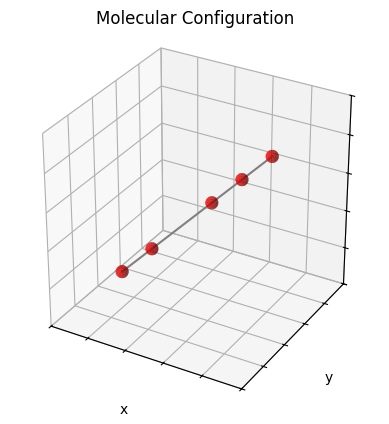

In [91]:
test = OrthorhombicCell(
    10, 10, 10, 5, 
    [[1],
     [0, 2],
     [1, 3],
     [2, 4],
     [3]
    ])
test.set_positions([[-1,-1,-1], [0,0,0], [2,2,2], [3,3,3], [4,4,4]])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
test.plot_atoms(ax, size=1, center=True)

In [92]:
test.inject_energy(
    lambda r: 1,
    lambda r: 2,
    lambda r: 3
)
test.get_PE()

19

In [93]:
k = 1.0
epsilon_repulsive = 1.0

r0 = 1.0
epsilon_attractive = 0.5
sigma = 1.0
test.inject_energy(
    lambda r: harmonic_PE(r, k, r0),
    lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
    lambda r: attractive_lj(r, sigma, epsilon_attractive)
)
test.get_PE()

2396580926.641792

In [95]:
class VelocityRescalingThermostat():
    """
    Velocity rescaling thermostat
    """
    def __init__(self, target_T, m):
        """
        VelocityRescalingThermostat(target_T)

        Parameters:
            target_T (K): target temperature
            m (g/mol): array of masses of the particles
        """
        self.target_T = target_T
        self.masses = m
        self.n = m.shape[0]

    def __call__(self, v):
        """
        Rescales the temperature.

        Parameters:
            v (angstrom/fs): 2D array of velocities
        """
        KE = 1/2*np.sum((self.masses * (np.linalg.norm(v, axis=1)**2)))
        KE_J = KE * 1e7 / constants.Avogadro # unit conversion
        cur_temp = 2/3 * KE_J / (self.n * constants.k)
        v *= np.sqrt(self.target_T / cur_temp)

In [96]:
class MDSimulation(ABC):
    """
    Molecular Dynamics Simulation.
    """
    box = None
    timestep = None # fs
    velocities = None
    n = 0
    masses = None # g/mol
    step = 0
    rescale_interval = None
    thermostat = None
    
    def set_force_field(self, forces, potentials):
        """
        Injects force field functions.

        Parameters:
            forces: dict of force functions. f(r_vec) (angstrom) -> N
            potentials: dict of potential functions. f(r) (angstrom) -> eV
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        """
        self.box.inject_force(forces['bonded'], forces['repulsive'], forces['attractive'])
        self.box.inject_energy(potentials['bonded'], potentials['repulsive'], potentials['attractive'])

    @abstractmethod
    def init_simulation(self, forces, potentials):
        """
        Initializes the system for simulation.

        Parameters:
            forces: dict of force functions. f(r_vec) (angstrom) -> N
            potentials: dict of potential functions. f(r) (angstrom) -> eV
            Both must contain keys 'bonded', 'attractive' and 'repulsive'.
        """
        pass
    
    def run(self):
        """
        Runs one time step of the MD simulation.
        """
        self.step += 1
        masses = self.masses.reshape(self.n, 1) / constants.Avogadro * 1e-3 # kg
        
        forces = self.box.get_forces() # N
        dv = 0.5 * forces / masses * self.timestep # N * fs / kg
        dv *= 1e-20 # angstrom / fs
        self.velocities += dv
        self.box.update_positions(self.velocities * self.timestep)
        forces = self.box.get_forces()
        dv = 0.5 * forces / masses * self.timestep
        dv *= 1e-20
        self.velocities += dv

        if self.step % self.rescale_interval == 0:
            self.thermostat(self.velocities)

In [97]:
class CoarseGrainPolymerChain(MDSimulation):
    """
    Simulation for a coarse grain polymer chain.
    """
    def init_particles(self, r0):
        """
        Initalizes the particle positions.

        Parameters:
            r0 (angstrom): bond length

        Returns:
            (positions, conn)
            positions: array of initialized positions
            conn: adjacency list of particle connectivity
        """
        conn = [[] for _ in range(self.n)]
        positions = np.zeros((self.n, 3))
        positions[0] = np.array([self.a/2, self.a/2, self.a/2])
        for i in range(1, self.n):
            direction = self.rng.random(3)
            direction /= np.linalg.norm(direction)
            positions[i] = positions[i-1] + r0*direction
            conn[i-1].append(i)
            conn[i].append(i-1)
        return positions, conn

    def init_velocities(self):
        """
        Initializes and sets the particle velocities 
        by drawing from the Maxwell-Boltzmann distribution and thermostating.
        """
        m = g_mol_to_kg(self.masses[0])
        std = np.sqrt(constants.k * self.temp / m)
        velocities = self.rng.normal(loc=0, scale=std, size=(self.n, 3))
        velocities -= np.mean(velocities, axis=0)
        self.velocities = velocities
        self.thermostat(self.velocities)

    def init_box(self):
        """
        Initializes the unit cell.
        """
        positions, conn = self.init_particles(self.r0)
        self.box = self.box_class(a, a, a, n, conn)
        self.box.set_positions(positions)
        self.box.wrap()

    def init_simulation(self, forces, potentials):
        self.init_box()
        self.init_velocities()
        self.set_force_field(forces, potentials)
        self.step = 0
    
    def __init__(
        self, 
        n, a, masses, r0, temp, box, timestep, 
        thermostat, rescale_interval, rng
    ):
        """
        CoarseGrainPolymerChain(n, masses, box, timestep, thermostat, rescale_interval)

        Parameters:
            n: number of particles
            a (angstrom): cubic box length
            masses (g/mol): int|array masses of particles
            r0 (angstrom): bond length of the polymer chain
            temp (K): target temperature
            box: a Cell class
            timestep (fs): simulation time step
            thermostat: a Thermostat class
            rescale_interval: number of steps to run between thermostating
            rng: random number generator
        """
        self.rng = rng
        self.n = n
        self.a = a
        self.r0 = r0
        self.masses = np.array(masses)
        if (len(self.masses.shape) == 0):
            self.masses = np.array([masses for _ in range(self.n)])
        self.timestep = timestep
        self.rescale_interval = rescale_interval
        self.temp = temp
        self.step = 0
        self.box_class = box
        self.thermostat = thermostat(temp, self.masses)

In [98]:
k = 1.0 # N/angstrom
epsilon_repulsive = 1.0 # eV

rng = np.random.default_rng(114514)
n = 30
a = 100 # angstrom
mass = 1 # g/mol
timestep = 2 # fs
r0 = 1.0 # angstrom
epsilon_attractive = 0.5 # eV
sigma = 1.0 # angstrom
temp = 0.1 * constants.eV / constants.k # K
rescale_interval = 100
test.inject_energy(
    lambda r: harmonic_PE(r, k, r0),
    lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
    lambda r: attractive_lj(r, sigma, epsilon_attractive)
)

chain = CoarseGrainPolymerChain(
    n=n, a=a, masses=mass, r0=r0, temp=temp, 
    box=OrthorhombicCell, timestep=timestep, 
    thermostat=VelocityRescalingThermostat,
    rescale_interval=rescale_interval, rng=rng
)

In [99]:
potentials = {
    "bonded": lambda r: harmonic_PE(r, k, r0),
    "repulsive": lambda r: repulsive_lj(r, sigma, epsilon_repulsive),
    "attractive": lambda r: attractive_lj(r, sigma, epsilon_attractive)
}
forces = {
    "bonded": lambda r_vec: harmonic_force(r_vec, k, r0),
    "attractive": lambda r_vec: repulsive_lj_force(r_vec, sigma, epsilon_repulsive),
    "repulsive": lambda r_vec: attractive_lj_force(r_vec, sigma, epsilon_attractive)
}
chain.init_simulation(forces, potentials)

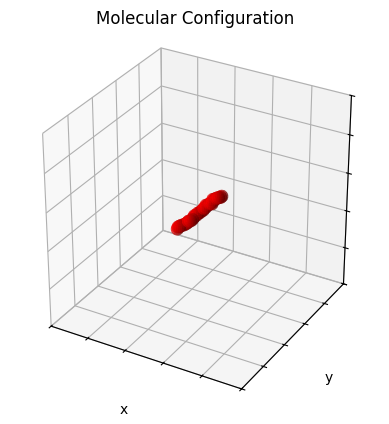

In [100]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
chain.box.plot_atoms(ax)

In [102]:
chain.box.get_PE()

-0.1716581218283221

In [105]:
for i in range(1000):
    chain.run()

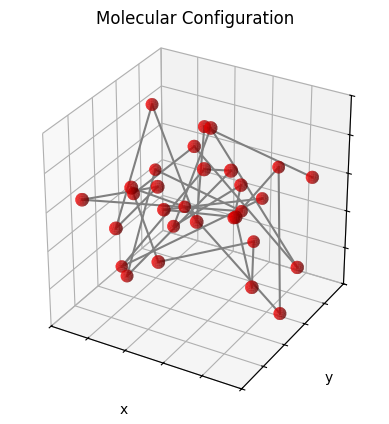

In [108]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
chain.box.plot_atoms(ax, center=True)